# ZAP Challenge - Regression training

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Imports

In [2]:
import pandas as pd
import numpy as np
import json
import re

from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from tqdm import tqdm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from joblib import dump, load

pd.set_option('display.max_columns', None)
plt.figure(figsize=(8,6))
sns.set(rc={'figure.figsize':(8,6)})

<Figure size 576x432 with 0 Axes>

## Carregamento do dataset

Os dados são disponibilizados no formato JSON, a estratéia aqui é adicionar os registros em um array e depois converte-lo em um DataFrame do pandas.

In [3]:
houses = []

for line in open('/content/drive/My Drive/zap_challenge/data/source-4-ds-train.json', 'r'):
    houses.append(json.loads(line))
    
data = json_normalize(houses)

print('Dataset size: {}'.format(len(data)))
data.head()

Dataset size: 133964


,address.city,address.country,address.district,address.geoLocation.location.lat,address.geoLocation.location.lon,address.geoLocation.precision,address.locationId,address.neighborhood,address.state,address.street,address.streetNumber,address.unitNumber,address.zipCode,address.zone,bathrooms,bedrooms,createdAt,description,id,images,listingStatus,owner,parkingSpaces,pricingInfos.businessType,pricingInfos.monthlyCondoFee,pricingInfos.period,pricingInfos.price,pricingInfos.rentalTotalPrice,pricingInfos.yearlyIptu,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,São Paulo,BR,,-23.612923,-46.614222,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,Jardim da Saúde,São Paulo,Rua Juvenal Galeno,53,,04290030,Zona Sul,3.0,4.0,2017-02-07T13:21:40Z,"04 dorms sendo 01 suíte e closet, sala de esta...",787c7bd19d,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,6.0,SALE,NaN,NaN,700000,NaN,NaN,STANDARD,f4603b2b52,1.0,PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,388.0,TWO_STORY_HOUSE,2018-12-06T19:27:12.623Z,388.0
1,São Paulo,BR,,-23.643962,-46.593475,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,Vila Santa Teresa (Zona Sul),São Paulo,Rua Juruaba,16,,04187320,Zona Sul,2.0,3.0,2016-03-21T18:35:17Z,"03 dorms sendo 01 suíte, sala, sala de jantar,...",4d68c0cdbe,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,2.0,SALE,NaN,NaN,336000,NaN,NaN,STANDARD,f4603b2b52,1.0,PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,129.0,HOME,2018-12-12T13:17:23.547Z,129.0
2,São Paulo,,,-23.568559,-46.647452,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,Bela Vista,São Paulo,Avenida Paulista,402,,01311000,,4.0,0.0,2018-12-18T23:47:03.425Z,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",e7e0b554ac,[http://static.nidoimovel.com.br/d3d9446802a44...,ACTIVE,False,5.0,RENTAL,4900.0,MONTHLY,24929,29829.0,4040.0,STANDARD,501f6d5e94,0.0,Excelente Conjunto Comercial na Av. Paulista,NaN,COMMERCIAL_PROPERTY,NaN,396.0
3,São Paulo,,,-23.598023,-46.682781,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Olimpia,Vila Olímpia,São Paulo,Rua Alvorada,1190,,04550004,,2.0,3.0,2018-10-26T16:18:28.915Z,"Viva melhor e de um jeito novo, com privilégio...",6654d93423,[https://vr-prod-vivapro-images.s3.amazonaws.c...,ACTIVE,False,2.0,SALE,686.0,NaN,739643,NaN,1610.0,STANDARD,527c7b0cc0,1.0,"Apartamento com 80m², 2 vagas próximo ao Parqu...",80.0,APARTMENT,2018-11-08T16:38:35.434Z,80.0
4,São Paulo,,,-23.582497,-46.653027,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Paraiso,Paraíso,São Paulo,Rua Curitiba,380,,04005030,,5.0,4.0,2018-12-14T18:06:51.342Z,Sua área é ocupada majoritariamente por instit...,9ffaf676ae,[https://vr-prod-vivapro-images.s3.amazonaws.c...,ACTIVE,False,5.0,SALE,6230.0,NaN,7520099,NaN,18900.0,STANDARD,527c7b0cc0,4.0,"Apartamento 332m², 4 suítes à venda próximo ao...",332.0,APARTMENT,2018-12-14T18:06:55.140Z,3322.0


## Removendo features que não serão utilizadas

In [4]:
dataset = data.drop(columns=['id','images','title','description','pricingInfos.yearlyIptu', 'updatedAt','createdAt','address.country','address.city','address.geoLocation.precision','address.locationId','address.state','address.streetNumber','address.unitNumber','address.zipCode','address.zone','publisherId','publicationType','address.district','listingStatus','owner', 'pricingInfos.rentalTotalPrice'])
dataset.head()

,address.geoLocation.location.lat,address.geoLocation.location.lon,address.neighborhood,address.street,bathrooms,bedrooms,parkingSpaces,pricingInfos.businessType,pricingInfos.monthlyCondoFee,pricingInfos.period,pricingInfos.price,suites,totalAreas,unitTypes,usableAreas
0,-23.612923,-46.614222,Jardim da Saúde,Rua Juvenal Galeno,3.0,4.0,6.0,SALE,NaN,NaN,700000,1.0,388.0,TWO_STORY_HOUSE,388.0
1,-23.643962,-46.593475,Vila Santa Teresa (Zona Sul),Rua Juruaba,2.0,3.0,2.0,SALE,NaN,NaN,336000,1.0,129.0,HOME,129.0
2,-23.568559,-46.647452,Bela Vista,Avenida Paulista,4.0,0.0,5.0,RENTAL,4900.0,MONTHLY,24929,0.0,NaN,COMMERCIAL_PROPERTY,396.0
3,-23.598023,-46.682781,Vila Olímpia,Rua Alvorada,2.0,3.0,2.0,SALE,686.0,NaN,739643,1.0,80.0,APARTMENT,80.0
4,-23.582497,-46.653027,Paraíso,Rua Curitiba,5.0,4.0,5.0,SALE,6230.0,NaN,7520099,4.0,332.0,APARTMENT,3322.0


## Preenchendo campos nulos

In [0]:
dataset['suites'].fillna(0, inplace=True)
dataset['parkingSpaces'].fillna(0, inplace=True)
dataset['bedrooms'].fillna(0, inplace=True)
dataset['bathrooms'].fillna(0, inplace=True)
dataset['pricingInfos.monthlyCondoFee'].fillna(1, inplace=True)
dataset['address.geoLocation.location.lat'].fillna(0, inplace=True)
dataset['address.geoLocation.location.lon'].fillna(0, inplace=True)

## Areas

Aqui serão preenchidos os campos "usableAreas" em branco com os valores de "totalAreas" que estiverem preenchidos, e os campos "totalAreas" em branco com os valores de "usableAreas" que estiverem preenchidos.

In [0]:
dataset['usableAreas'] = dataset['usableAreas'].fillna(dataset['totalAreas'])

def fill_zero(row):
  if row['usableAreas'] == 0:
    row['usableAreas'] = row['totalAreas']

  return row

dataset = dataset.apply(lambda row: fill_zero(row), axis=1)
dataset = dataset.drop(columns=['totalAreas'], axis=1)
dataset['usableAreas'].fillna(1, inplace=True)
dataset['usableAreas'] = dataset['usableAreas'].replace(0, 1)

## Condominio

In [0]:
dataset['pricingInfos.monthlyCondoFee'] = dataset['pricingInfos.monthlyCondoFee'].replace(0, 1)

## Posições geográficas

In [8]:
pos_zero = dataset[dataset['address.geoLocation.location.lat']==0]
print('{} registros com posições geograficas igual a 0'.format(len(pos_zero)))

17 registros com posições geograficas igual a 0


Como os registros sem posições geograficas têm outras informações de endereço, as posições serão preenchidas com o auxilio de uma api.

In [0]:
geolocator = Nominatim(user_agent="zap_challenge")

for index, row in pos_zero.iterrows():
  neighborhood = re.sub(r'\([^)]*\)', '', row['address.neighborhood']).strip()
  location = geolocator.geocode('{0}, {1}, São Paulo'.format(row['address.street'], neighborhood))
  
  if location is not None:
    dataset.loc[index, 'address.geoLocation.location.lat'] = location.latitude
    dataset.loc[index, 'address.geoLocation.location.lon'] = location.longitude

Alguns registros não são retornados, neste caso usaremos a media das posições em cada bairro para preencher os registros ainda sem posição

In [10]:
pos_zero = dataset[dataset['address.geoLocation.location.lat'] == 0]
print('{} registros com posições geograficas igual a 0'.format(len(pos_zero)))

10 registros com posições geograficas igual a 0


In [0]:
pos_zero = dataset[dataset['address.geoLocation.location.lon'] == 0]

for index, row in pos_zero.iterrows():
  lat_mean = dataset[dataset['address.neighborhood']==row['address.neighborhood']]['address.geoLocation.location.lat'].mean()
  lon_mean = dataset[dataset['address.neighborhood']==row['address.neighborhood']]['address.geoLocation.location.lon'].mean()
  dataset.loc[index, 'address.geoLocation.location.lat'] = lat_mean
  dataset.loc[index, 'address.geoLocation.location.lon'] = lon_mean

Uma vez que os reistros agora estão com as coordenadas geograficas preenchidas, os dados de endereço não serão mais necessários

In [12]:
dataset.drop(columns=['address.neighborhood','address.street'], inplace=True)
dataset.head()

,address.geoLocation.location.lat,address.geoLocation.location.lon,bathrooms,bedrooms,parkingSpaces,pricingInfos.businessType,pricingInfos.monthlyCondoFee,pricingInfos.period,pricingInfos.price,suites,unitTypes,usableAreas
0,-23.612923,-46.614222,3.0,4.0,6.0,SALE,1.0,NaN,700000,1.0,TWO_STORY_HOUSE,388.0
1,-23.643962,-46.593475,2.0,3.0,2.0,SALE,1.0,NaN,336000,1.0,HOME,129.0
2,-23.568559,-46.647452,4.0,0.0,5.0,RENTAL,4900.0,MONTHLY,24929,0.0,COMMERCIAL_PROPERTY,396.0
3,-23.598023,-46.682781,2.0,3.0,2.0,SALE,686.0,NaN,739643,1.0,APARTMENT,80.0
4,-23.582497,-46.653027,5.0,4.0,5.0,SALE,6230.0,NaN,7520099,4.0,APARTMENT,3322.0


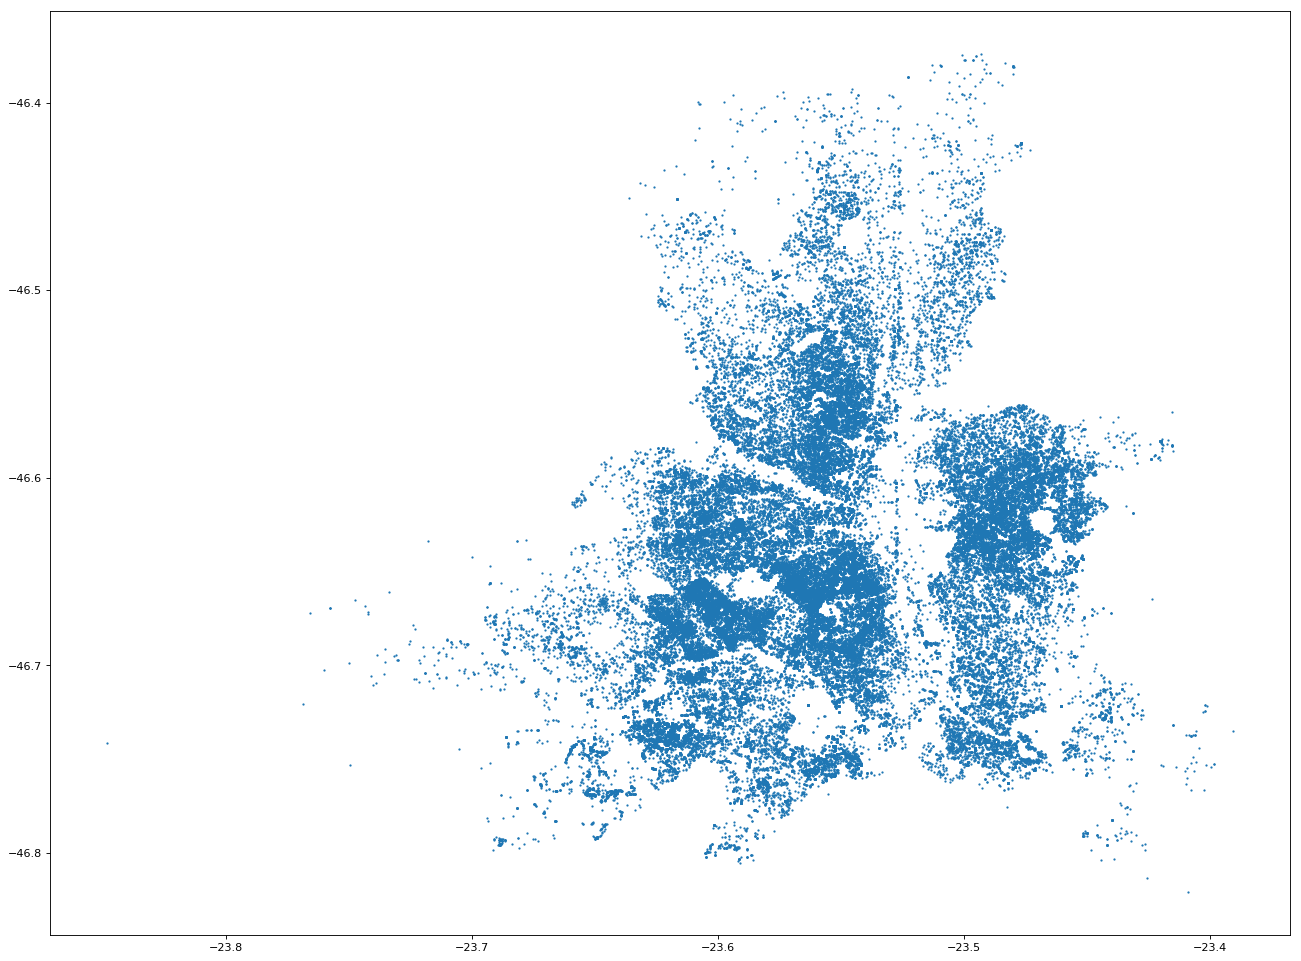

In [55]:
map_data = dataset[['address.geoLocation.location.lat', 'address.geoLocation.location.lon', 'pricingInfos.price']]
map_data = map_data[map_data['address.geoLocation.location.lat'] < -23]
map_data = map_data[map_data['address.geoLocation.location.lon'] < -46]
plt.style.use('fast')
plt.figure(figsize=(20, 15), dpi=80)
plt.scatter(map_data['address.geoLocation.location.lat'].values, map_data['address.geoLocation.location.lon'].values, s=1)
plt.show()

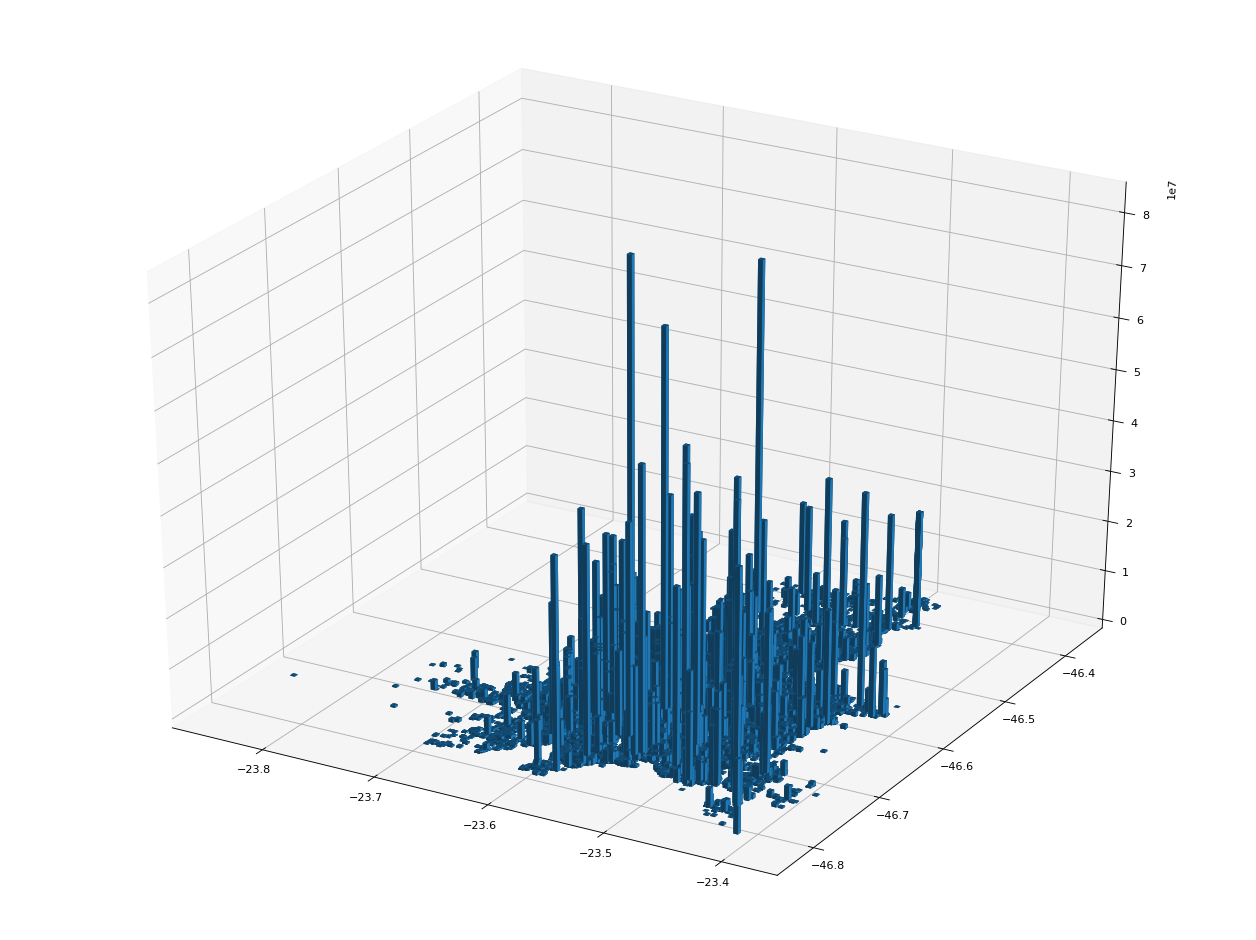

In [54]:
map_data = dataset[['address.geoLocation.location.lat', 'address.geoLocation.location.lon', 'pricingInfos.price']]
map_data = map_data[map_data['address.geoLocation.location.lat'] < -23]
map_data = map_data[map_data['address.geoLocation.location.lon'] < -46]
plt.style.use('default')
fig = plt.figure(figsize=(20,15), dpi=80)
ax = fig.add_subplot(111, projection='3d')

x = map_data['address.geoLocation.location.lat'].values
y = map_data['address.geoLocation.location.lon'].values
dz = map_data['pricingInfos.price'].values
z = np.zeros(len(x))

ax.bar3d(x, y, z, 0.004, 0.004, dz, alpha=0.5)
plt.show()

## Preços

Alguns registros contém periodos de pagamento diario e anual, como são poucos reistros eles serão convertidos para mensal, como a maioria do dataset é, para não preudicar o desempenho do modelo gerado.

In [15]:
daily_rentals = dataset[dataset['pricingInfos.period']=='DAILY']

for index, row in daily_rentals.iterrows():
  monthly = row['pricingInfos.price']*31
  dataset.loc[index, 'pricingInfos.price'] = monthly
  dataset.loc[index, 'pricingInfos.period'] = 'MONTHLY'

print('{} registros de aluguel diario convertidos para aluguel mensal'.format(len(daily_rentals)))

19 registros de aluguel diario convertidos para aluguel mensal


In [16]:
yearly_rentals = dataset[dataset['pricingInfos.period']=='YEARLY']

for index, row in yearly_rentals.iterrows():
  monthly = row['pricingInfos.price']/12
  dataset.loc[index, 'pricingInfos.price'] = monthly
  dataset.loc[index, 'pricingInfos.period'] = 'MONTHLY'

print('{} registros de aluguel anual convertidos para aluguel mensal'.format(len(yearly_rentals)))

3 registros de aluguel anual convertidos para aluguel mensal


Uma vez que agora todos os registros de aluguel são mensais, não será mais necessario o campo "pricingInfos.period".


In [17]:
dataset.drop(columns=['pricingInfos.period'], inplace=True)
dataset.head()

,address.geoLocation.location.lat,address.geoLocation.location.lon,bathrooms,bedrooms,parkingSpaces,pricingInfos.businessType,pricingInfos.monthlyCondoFee,pricingInfos.price,suites,unitTypes,usableAreas
0,-23.612923,-46.614222,3.0,4.0,6.0,SALE,1.0,700000.0,1.0,TWO_STORY_HOUSE,388.0
1,-23.643962,-46.593475,2.0,3.0,2.0,SALE,1.0,336000.0,1.0,HOME,129.0
2,-23.568559,-46.647452,4.0,0.0,5.0,RENTAL,4900.0,24929.0,0.0,COMMERCIAL_PROPERTY,396.0
3,-23.598023,-46.682781,2.0,3.0,2.0,SALE,686.0,739643.0,1.0,APARTMENT,80.0
4,-23.582497,-46.653027,5.0,4.0,5.0,SALE,6230.0,7520099.0,4.0,APARTMENT,3322.0


## Variaveis categoricas

Aqui, as variaveis categoricas serão codificadas como dummy variables, esta técnica é também chamada de One Hot Encoding.

In [18]:
dataset = pd.get_dummies(dataset)
dataset.head()

,address.geoLocation.location.lat,address.geoLocation.location.lon,bathrooms,bedrooms,parkingSpaces,pricingInfos.monthlyCondoFee,pricingInfos.price,suites,usableAreas,pricingInfos.businessType_RENTAL,pricingInfos.businessType_SALE,unitTypes_APARTMENT,unitTypes_BUSINESS,unitTypes_CLINIC,unitTypes_COMMERCIAL_ALLOTMENT_LAND,unitTypes_COMMERCIAL_BUILDING,unitTypes_COMMERCIAL_PROPERTY,unitTypes_CONDOMINIUM,unitTypes_COUNTRY_HOUSE,unitTypes_FARM,unitTypes_FLAT,unitTypes_HOME,unitTypes_KITNET,unitTypes_OFFICE,unitTypes_PENTHOUSE,unitTypes_RESIDENTIAL_ALLOTMENT_LAND,unitTypes_RESIDENTIAL_BUILDING,unitTypes_SHED_DEPOSIT_WAREHOUSE,unitTypes_STORE,unitTypes_TWO_STORY_HOUSE
0,-23.612923,-46.614222,3.0,4.0,6.0,1.0,700000.0,1.0,388.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-23.643962,-46.593475,2.0,3.0,2.0,1.0,336000.0,1.0,129.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,-23.568559,-46.647452,4.0,0.0,5.0,4900.0,24929.0,0.0,396.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-23.598023,-46.682781,2.0,3.0,2.0,686.0,739643.0,1.0,80.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-23.582497,-46.653027,5.0,4.0,5.0,6230.0,7520099.0,4.0,3322.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Variaveis categoricas agora estão convertidas para colunas booleanas, o que significa que uma das colunas de cada variavel gerada pode ser removida sem afetar o resultado final.

In [0]:
dataset.drop(columns=['pricingInfos.businessType_RENTAL', 'unitTypes_COMMERCIAL_BUILDING'], inplace=True)

## Variaveis continuas

É possivel observar que as 3 features com maiores correlações com o preço do imóvel são:
  - suites
  - princigInfos.businessType
  - bathrooms

Neste caso seria possivel utilizar apenas essas 3 variaveis e ainda ter algum resultado minimamente eficiente.

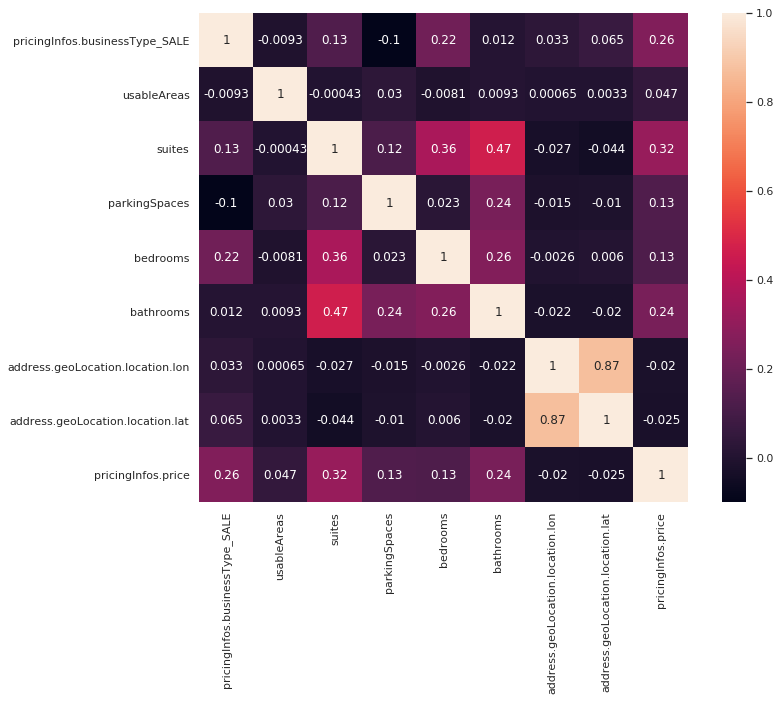

In [20]:
corrmat = dataset[['pricingInfos.businessType_SALE', 'usableAreas', 'suites', 'parkingSpaces', 'bedrooms', 'bathrooms', 'address.geoLocation.location.lon' ,'address.geoLocation.location.lat', 'pricingInfos.price']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True);

### Adicionando features polinomiais e logaritmicas.

A adição de features de maior complexidade linear ao modelo ajuda a melhorar a complexidade do modelo em si.

In [21]:
columns = ['usableAreas', 'suites', 'parkingSpaces', 'bedrooms', 'bathrooms', 'pricingInfos.monthlyCondoFee']

poly = PolynomialFeatures(2)
cols = dataset[columns]

xp = poly.fit_transform(cols)
pcols = poly.get_feature_names(cols.columns)

polynomials = pd.DataFrame(xp, columns=pcols)
polynomials['usableAreas_log'] = np.log(polynomials['usableAreas'])
polynomials['pricingInfos.monthlyCondoFee_log'] = np.log(polynomials['pricingInfos.monthlyCondoFee'])
polynomials = polynomials.drop(columns=columns, axis=1)
polynomials.head()

for col in dataset.columns.values:
  polynomials[col] = dataset[col].values

polynomials.head()

,1,usableAreas^2,usableAreas suites,usableAreas parkingSpaces,usableAreas bedrooms,usableAreas bathrooms,usableAreas pricingInfos.monthlyCondoFee,suites^2,suites parkingSpaces,suites bedrooms,suites bathrooms,suites pricingInfos.monthlyCondoFee,parkingSpaces^2,parkingSpaces bedrooms,parkingSpaces bathrooms,parkingSpaces pricingInfos.monthlyCondoFee,bedrooms^2,bedrooms bathrooms,bedrooms pricingInfos.monthlyCondoFee,bathrooms^2,bathrooms pricingInfos.monthlyCondoFee,pricingInfos.monthlyCondoFee^2,usableAreas_log,pricingInfos.monthlyCondoFee_log,address.geoLocation.location.lat,address.geoLocation.location.lon,bathrooms,bedrooms,parkingSpaces,pricingInfos.monthlyCondoFee,pricingInfos.price,suites,usableAreas,pricingInfos.businessType_SALE,unitTypes_APARTMENT,unitTypes_BUSINESS,unitTypes_CLINIC,unitTypes_COMMERCIAL_ALLOTMENT_LAND,unitTypes_COMMERCIAL_PROPERTY,unitTypes_CONDOMINIUM,unitTypes_COUNTRY_HOUSE,unitTypes_FARM,unitTypes_FLAT,unitTypes_HOME,unitTypes_KITNET,unitTypes_OFFICE,unitTypes_PENTHOUSE,unitTypes_RESIDENTIAL_ALLOTMENT_LAND,unitTypes_RESIDENTIAL_BUILDING,unitTypes_SHED_DEPOSIT_WAREHOUSE,unitTypes_STORE,unitTypes_TWO_STORY_HOUSE
0,1.0,150544.0,388.0,2328.0,1552.0,1164.0,388.0,1.0,6.0,4.0,3.0,1.0,36.0,24.0,18.0,6.0,16.0,12.0,4.0,9.0,3.0,1.0,5.961005,0.000000,-23.612923,-46.614222,3.0,4.0,6.0,1.0,700000.0,1.0,388.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,16641.0,129.0,258.0,387.0,258.0,129.0,1.0,2.0,3.0,2.0,1.0,4.0,6.0,4.0,2.0,9.0,6.0,3.0,4.0,2.0,1.0,4.859812,0.000000,-23.643962,-46.593475,2.0,3.0,2.0,1.0,336000.0,1.0,129.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1.0,156816.0,0.0,1980.0,0.0,1584.0,1940400.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,20.0,24500.0,0.0,0.0,0.0,16.0,19600.0,24010000.0,5.981414,8.496990,-23.568559,-46.647452,4.0,0.0,5.0,4900.0,24929.0,0.0,396.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,6400.0,80.0,160.0,240.0,160.0,54880.0,1.0,2.0,3.0,2.0,686.0,4.0,6.0,4.0,1372.0,9.0,6.0,2058.0,4.0,1372.0,470596.0,4.382027,6.530878,-23.598023,-46.682781,2.0,3.0,2.0,686.0,739643.0,1.0,80.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,11035684.0,13288.0,16610.0,13288.0,16610.0,20696060.0,16.0,20.0,16.0,20.0,24920.0,25.0,20.0,25.0,31150.0,16.0,20.0,24920.0,25.0,31150.0,38812900.0,8.108322,8.737132,-23.582497,-46.653027,5.0,4.0,5.0,6230.0,7520099.0,4.0,3322.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Treinamento dos modelos

In [0]:
x_full = polynomials.values
y_full = np.log(dataset['pricingInfos.price'].values)

x, x_validation, y, y_validation = train_test_split(x_full, y_full, test_size=0.33, random_state=42)

O treino dos modelos utiliza a técnica de cross folding.

In [44]:
test_errors_GBR = []
test_errors_lasso = []
test_errors_ENet = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
split_count = 0

for train_index, test_index in kf.split(x):
  split_count += 1
  
  print('Running split {}'.format(split_count))
  
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # Gradient boosting regressor
  print('- Training Gradient boosting regressor')
  mGBR = make_pipeline(RobustScaler(),GradientBoostingRegressor(n_estimators=2000, learning_rate=0.02,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=30,
                                  loss='huber', random_state = 5))

  mGBR.fit(x_train,y_train)
  pred_test_GBR = mGBR.predict(x_test)
  test_errors_GBR.append(np.square(np.array(pred_test_GBR) - np.array(y_test)).mean() ** 0.5)

  # Lasso
  print('- Training Lasso')
  mLasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.003, random_state=5, max_iter=50000))
  mLasso.fit(x_train, y_train)
  pred_test_lasso = mLasso.predict(x_test)
  test_errors_lasso.append(np.square(np.array(pred_test_lasso) - np.array(y_test)).mean() ** 0.5)

  # ElasticNet
  print('- Training ElasticNet')
  mENet = make_pipeline(RobustScaler(), ElasticNet(alpha=4.0, l1_ratio=0.005, random_state=3))
  mENet.fit(x_train, y_train)
  pred_test_ENet = mENet.predict(x_test)
  test_errors_ENet.append(np.square(np.array(pred_test_ENet) - np.array(y_test)).mean() ** 0.5)

print('Error for GBR:\t{}'.format(np.mean(test_errors_GBR)))
print('Error for Lasso:\t{}'.format(np.mean(test_errors_lasso)))
print('Error for ENet:\t{}'.format(np.mean(test_errors_ENet)))

Running split 1
- Training Gradient boosting regressor
- Training Lasso
- Training ElasticNet
Running split 2
- Training Gradient boosting regressor
- Training Lasso
- Training ElasticNet


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.81326108268695, tolerance: 34.58182477399315
  positive)


Running split 3
- Training Gradient boosting regressor
- Training Lasso
- Training ElasticNet
Running split 4
- Training Gradient boosting regressor
- Training Lasso
- Training ElasticNet


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.66964605727117, tolerance: 34.5323601088547
  positive)


Running split 5
- Training Gradient boosting regressor
- Training Lasso
- Training ElasticNet
Error for GBR:	0.0953243863718725
Error for Lasso:	8.812071180277764
Error for ENet:	4.521669425281617


## Validação dos modelos

In [42]:
validation_errors_GBR = []
validation_errors_lasso = []
validation_errors_ENet = []

pred_test_GBR = mGBR.predict(x_validation)
validation_errors_GBR.append(np.square(np.array(pred_test_GBR) - np.array(y_validation)).mean() ** 0.5)

pred_test_lasso = mLasso.predict(x_validation)
validation_errors_lasso.append(np.square(np.array(pred_test_lasso) - np.array(y_validation)).mean() ** 0.5)

pred_test_ENet = mENet.predict(x_validation)
validation_errors_ENet.append(np.square(np.array(pred_test_ENet) - np.array(y_validation)).mean() ** 0.5)

print('Error for GBR:\t{}'.format(np.mean(validation_errors_GBR)))
print('Error for Lasso:\t{}'.format(np.mean(validation_errors_lasso)))
print('Error for ENet:\t{}'.format(np.mean(validation_errors_ENet)))

Error for GBR:	0.0987853198815534
Error for Lasso:	0.6508625660080734
Error for ENet:	2.172479858463271


## Salvando os modelos gerados


In [43]:
dump(mGBR, '/content/drive/My Drive/zap_challenge/models/gbr.joblib')
dump(mLasso, '/content/drive/My Drive/zap_challenge/models/lasso.joblib')
dump(mENet, '/content/drive/My Drive/zap_challenge/models/enet.joblib')

['/content/drive/My Drive/zap_challenge/models/enet.joblib']

## Teste interativo


### Teste em um registro em particular

Carregando o modelo salvo para testar sua execução para processo de predição do dataset de teste.

In [0]:
MODEL_PATH = '/content/drive/My Drive/zap_challenge/gbr.joblib'
model = load(MODEL_PATH)

Modificando o valor de i é possivel fazer a predição para o i-ésimo registro do dataframe e checar com mais detalhes a predição performada.

In [0]:
i = 15

def get_prediction(x):
  return int(np.exp(model.predict([x])[0]))

pred = get_prediction(x[i])

print('Pred:\t{}'.format(pred))
print('Value:\t{}'.format(int(np.exp(y[i]))))

## Perormance

### Perormance em todo o dataset

In [0]:
MODEL_PATH = '/content/drive/My Drive/zap_challenge/gbr.joblib'
model = load(MODEL_PATH)

test_errors = []

y_pred = model.predict(x)
test_errors.append(np.square(np.array(y_pred) - np.array(y)).mean() ** 0.5)

print(np.mean(test_errors))

### Performance por bairro

Para esta verificação será feita a predição dos preços das casas em cada bairro e medido o erro do modelo, os resultados serão então ordenados pelo erro.

In [0]:
def check_perf_neighborhood(model):
    data_neighborhood = data.groupby('address.neighborhood')
    neighborhood_errors = pd.DataFrame(columns=['neighborhood', 'error'])

    for group_name, df_group in tqdm(data_neighborhood):
        test_errors = []
        xn = polynomials.loc[df_group.index.values,:].values
        yn = np.log(dataset.loc[df_group.index.values, ['pricingInfos.price']].values)
        y_pred = model.predict(xn)

        test_errors.append(np.square(np.array(y_pred) - np.array(yn)).mean() ** 0.5)
        neighborhood_errors = neighborhood_errors.append({'neighborhood' : group_name , 'error' : np.mean(test_errors)} , ignore_index=True)

    neighborhood_errors = neighborhood_errors.sort_values(by=['error'])
    print(neighborhood_errors.head(10))

In [51]:
print('Calculating performance for Gradient Boosting Regressor')
check_perf_neighborhood(load('/content/drive/My Drive/zap_challenge/models/gbr.joblib'))

Calculating performance for Gradient Boosting Regressor


100%|██████████| 1634/1634 [00:18<00:00, 89.38it/s] 


                                neighborhood     error
628                         Jardim República  0.000120
1422                       Vila Nova Jaragua  0.000444
515                            Jardim Marcel  0.000567
735                          Jardim São Remo  0.000745
197   Conjunto Residencial Salvador Tolezani  0.001812
354                           Jardim Cidalia  0.002503
494                             Jardim Lidia  0.002971
839                         Jd IV Centenário  0.003323
1620                              Vl. Mazzei  0.003586
1231                            Vila Corberi  0.003623


In [52]:
print('Calculating performance for Lasso')
check_perf_neighborhood(load('/content/drive/My Drive/zap_challenge/models/lasso.joblib'))

  0%|          | 0/1634 [00:00<?, ?it/s]

Calculating performance for Lasso


100%|██████████| 1634/1634 [00:12<00:00, 130.65it/s]


                neighborhood     error
950           Parque Pereira  0.001697
148            Cidade Vargas  0.002759
1385               Vila Mira  0.007480
519     Jardim Maria Eugênia  0.007681
1572  Vila Uniao(Zona Norte)  0.014263
235                   I Bibi  0.017863
1608             Vl Bertioga  0.019412
841             Jd Marajoara  0.026067
1109             Vila Aimore  0.027785
838               Jd Guedala  0.030824


In [53]:
print('Calculating performance for ElasticNet')
check_perf_neighborhood(load('/content/drive/My Drive/zap_challenge/models/enet.joblib'))

  0%|          | 0/1634 [00:00<?, ?it/s]

Calculating performance for ElasticNet


100%|██████████| 1634/1634 [00:12<00:00, 156.26it/s]


                             neighborhood     error
199   Conjunto Residencial Sitio Oratorio  0.002888
894                      Parada de Taipas  0.011834
490             Jardim Leônidas Moreira I  0.016350
482                        Jardim Lageado  0.017630
536                       Jardim Miragaia  0.027556
843                          Jd S Roberto  0.033671
1586                          Vila Zefira  0.035310
1148                           Vila Aurea  0.039156
1002                            Patriarca  0.043369
49                    C. P. Man. de Paiva  0.044540
